In [1]:
import os
import math
from collections import namedtuple
from multiprocessing import Pool
import json

import numpy as np
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import h5py


In [2]:
QUERY_COUNT = 1000
ITEM_COUNT = 10 ** 6
GT_TOP_LEN = 10000
RECALL_TOP_LEN = 5

MIN_EF_SEARCH = 1
MAX_EF_SEARCH = 10000
RECALL_OF_INTEREST = 0.95
N_SEARCH_THREADS = 8 # Each thread consumes 4 GB RAM
RECALC_RESULTS = False
M_RANGE = [4, 8, 16, 32, 64, 128]


In [21]:
def read_fvecs(file_name):
    a = np.fromfile(file_name, dtype="int32")
    dim = a[0]
    return a.view("float32").reshape((-1, dim + 1))[:,1:]

def normalize(a):
    vec_lengths = np.sqrt(np.power(a, 2).sum(axis=1, keepdims=True))
    assert np.all(vec_lengths > 1e-9)
    return a / vec_lengths

def calc_pairwise_relevance(i, q):
    return pairwise_distances(i, q, metric="cosine").astype("float32")

def prepare_data(dataset, dim, items, train_queries, test_queries):    
    assert train_queries.shape == (QUERY_COUNT, dim)
    assert test_queries.shape == (QUERY_COUNT, dim)
    assert items.shape == (ITEM_COUNT, dim)
    
    items = normalize(items)
    train_queries = normalize(train_queries)
    test_queries = normalize(test_queries)

    os.makedirs("data/{}/data/model_scores".format(dataset), exist_ok=True)
    train_queries.tofile("data/{}/data/train_queries.bin".format(dataset))
    test_queries.tofile("data/{}/data/test_queries.bin".format(dataset))
    items.tofile("data/{}/data/items.bin".format(dataset))

    print("compute ground truth test scores for {}".format(dataset))
    gt_train_scores = calc_pairwise_relevance(items, train_queries)
    gt_train_scores.tofile("data/{}/data/model_scores/gt_train_scores.bin".format(dataset))
    del gt_train_scores

    gt_test_scores = calc_pairwise_relevance(items, test_queries)
    gt_test_scores.tofile("data/{}/data/model_scores/gt_test_scores.bin".format(dataset))
    
    print("Calc ground truth nearest neighbors for {}".format(dataset))
    scores_path = "data/{}/data/model_scores/gt_test_scores.bin".format(dataset)
    gt = (-gt_test_scores).argsort(axis=0)[:GT_TOP_LEN,:].T.astype("int32")
    gt.tofile("data/{}/data/model_scores/groundtruth_test.bin".format(dataset))


In [7]:
def prepare_glove():
    print("Prepare glove data")
    # the hdf5 file is taken from here: https://github.com/erikbern/ann-benchmarks
    with h5py.File("data/glove/glove-25-angular.hdf5", "r") as f:
        glove_base = f["train"][:]
        glove_query = f['test'][:]
        
#     print(glove_base.shape, glove_query.shape)

    np.random.seed(0)
    np.random.shuffle(glove_base)
    np.random.shuffle(glove_query)

    train_queries = glove_query[:QUERY_COUNT]
    test_queries = glove_query[QUERY_COUNT: 2 * QUERY_COUNT]
    items = glove_base[:ITEM_COUNT]

    prepare_data("glove", 25, items, train_queries, test_queries)


def prepare_sift():
    print("Prepare sift data")
    # The data is taken from here:
    # https://www.dropbox.com/sh/noqdusnt11y6y5t/AACcl6mL5JAjZRN5AaKlta1ra?dl=0
    
    sift_base = read_fvecs("data/sift/sift_base.fvecs")
    sift_query = read_fvecs("data/sift/sift_query.fvecs")
    assert 2 * QUERY_COUNT <= sift_query.shape[0]
    assert sift_base.shape == (ITEM_COUNT, 128)

#     print(sift_base.shape, sift_query.shape)

    np.random.seed(0)
    np.random.shuffle(sift_query)
    train_queries = sift_query[:QUERY_COUNT]
    test_queries = sift_query[QUERY_COUNT: 2 * QUERY_COUNT]
    items = sift_base[:ITEM_COUNT]

    prepare_data("sift", 128, items, train_queries, test_queries)

def prepare_deep96():
    # The data is taken from here: http://sites.skoltech.ru/compvision/noimi/
    deep_base = read_fvecs("data/deep1M/deep10M.fvecs")
    deep_query = read_fvecs("data/deep1M/deep1B_queries.fvecs")
    assert 2 * QUERY_COUNT <= deep_query.shape[0]

    np.random.seed(0)
    np.random.shuffle(deep_base)
    np.random.shuffle(deep_query)
    
    train_queries = deep_query[:QUERY_COUNT]
    test_queries = deep_query[QUERY_COUNT: 2 * QUERY_COUNT]    
    items = deep_base[:ITEM_COUNT]

    prepare_data("deep1M", 96, items, train_queries, test_queries)

def prepare_deep256():
    # The data is from here:
    # http://sites.skoltech.ru/compvision/projects/aqtq/
    items = read_fvecs("data/deep256/deep1M_base.fvecs")
    learn = read_fvecs("data/deep256/deep1M_learn.fvecs")
    test_queries = read_fvecs("data/deep256/deep1M_queries.fvecs")

    assert items.shape == (ITEM_COUNT, 256)
    assert test_queries.shape == (QUERY_COUNT, 256)
    
    np.random.seed(0)
    np.random.shuffle(learn)
    train_queries = learn[:QUERY_COUNT]

    prepare_data("deep256", 256, items, train_queries, test_queries)

In [ ]:
prepare_glove()

In [22]:
prepare_sift()
prepare_deep96()
prepare_deep256()

Prepare sift data
compute ground truth test scores for sift
Calc ground truth nearest neighbors for sift
compute ground truth test scores for deep1M
Calc ground truth nearest neighbors for deep1M
compute ground truth test scores for deep256
Calc ground truth nearest neighbors for deep256


In [9]:
build_graph_cmd_template = (
    "./RPG --mode base "
    "--baseSize 1000000 "
    "--trainQueries {featuresSize} "
    "--base data/{dataset}/data/{features}.bin "
    "--outputGraph {graphPath} "
    "--relevanceVector {featuresSize} "
    "--efConstruction 1000 --M {M} "
    "--metric l2"
)

def build_graph(dataset, graph_path, features, dim, degree, recalc=False):
    if os.path.isfile(graph_path) and not recalc:
        return
    cmd = build_graph_cmd_template.format(
        dataset=dataset,
        featuresSize=dim,
        features=features,
        graphPath=graph_path,
        M=degree
    )
    print(cmd)
    os.system(cmd)


In [10]:
search_cmd_template = (
    "./RPG --mode query --baseSize 1000000 --querySize 1000"
    " --query data/{dataset}/data/model_scores/{scores} --inputGraph {inputGraph}"
    " --efSearch {efSearch} --topK {topK} --output data/{dataset}/{searchResultFile}.txt" +
    " --gtQueries 1000 --gtTop {} ".format(GT_TOP_LEN) +
    "--groundtruth data/{dataset}/data/model_scores/{gtFile}"
)

In [11]:
def sort_by(results, key):
    assert key in ["evals", "efSearch"]
    permutation = np.argsort(results[key])
    for key in results:
        vals = results[key]
        results[key] = [vals[i] for i in permutation]
    return results

assert sort_by({
    "efSearch": [2, 0, 3, 1],
    "vals": [1, 2, 3, 4]}, "efSearch") == {
    "efSearch": [0, 1, 2, 3],
    "vals": [2, 4, 1, 3]
}

In [12]:
def get_evals_for_recall(results, recall=RECALL_OF_INTEREST):
    results = sort_by(results, "evals")
    evals = results["evals"]
    recalls = results["recall"]
    ef_serch = results["efSearch"] if "efSearch" in results else evals
    assert len(evals) == len(recalls)
    
    lower_bound = 0
    lower_bound_ef = MIN_EF_SEARCH
    upper_bound = math.inf
    upper_bound_ef = MAX_EF_SEARCH
    
    if not evals:
        return lower_bound, upper_bound
    
    
    if recalls[0] <= recall:
        lower_bound = evals[0]
        lower_bound_ef = ef_serch[0]
        i = 1
        while i < len(evals) and recalls[i] <= recall:
            lower_bound = evals[i]
            lower_bound_ef = ef_serch[i]
            i += 1
    
    if recalls[-1] >= recall:
        upper_bound = evals[-1]
        upper_bound_ef = ef_serch[-1]
        i = len(evals) - 2
        while i >= 0 and recalls[i] >= recall:
            upper_bound = evals[i]
            upper_bound_ef = ef_serch[i]
            i -= 1
    
    return (lower_bound, upper_bound), (lower_bound_ef, upper_bound_ef)

assert get_evals_for_recall({
    "evals": [0, 1, 2, 3, 4],
    "recall": [0.93, 0.94, 0.95, 0.96, 0.97]
}) == ((2, 2), (2, 2))
assert get_evals_for_recall({
    "evals": [0, 1, 2, 3, 4],
    "recall": [0.93, 0.94, 0.955, 0.96, 0.97]
}) == ((1, 2), (1, 2))
assert get_evals_for_recall({
    "evals": [0, 1, 2, 3, 4],
    "recall": [0.93, 0.96, 0.94, 0.96, 0.97]
}) == ((0, 3), (0, 3))


In [13]:
def merge_results(lhs_res, rhs_res):
    assert not rhs_res or sorted(lhs_res.keys()) == sorted(rhs_res.keys())
    merged_res = {}
    for key in lhs_res:
        merged_res[key] = list(lhs_res[key]) + list(rhs_res.get(key, []))
    return merged_res


In [14]:
def logspace(start, stop, count, include_ends=True):
    cnt_ = count if include_ends else count + 2
    seq = np.unique(np.exp(
        np.linspace(np.log(start), np.log(stop), cnt_)
    ).astype("int"))
    if include_ends:
        return seq
    return seq[1:-1]

In [15]:
def bench_cmd(cmd):
    res = {}
    cmd_out = []
    with os.popen(cmd) as out:
        for line in out:
            cmd_out.append(line)
            for stat_name, prefix, suff_len in [
                ("relevance", "Average relevance: ", 1),
                ("recall", "Recall@5: ", 1),
                ("time", "Average query time: ", 3),
                ("evals", "Average number of model computations: ", 1)
            ]:
                if line.startswith(prefix):
                    res[stat_name] = float(line[len(prefix):-suff_len])
    return res, "".join(cmd_out)

def run_search(graph_path, scores_file, ef_ticks, dataset,
               topK=5, result_file=None, n_threads=8, verbose=True,
               gt_file="groundtruth_test.bin"
              ):
    if result_file is None:
        result_file = "result"
    else:
        assert len(ef_ticks) == 1
    
    commands = []
    for ef in ef_ticks:
        commands.append(search_cmd_template.format(
            dataset=dataset,
            scores=scores_file,
            inputGraph=graph_path,
            efSearch=ef,
            topK=topK,
            searchResultFile=result_file,
            gtFile=gt_file
        ))
    pool = Pool(processes=n_threads)
    results = pool.map(bench_cmd, commands)
    output = {"relevance": [], "recall": [], "time": [], "evals": []}
    for i, (res, cmd_out) in enumerate(results):
        if all(key in res for key in output):
            for key in output:
                output[key].append(res[key])
        else:
            if verbose:
                print("missed result for {} efSearch {}.".format(graph_path, ef_ticks[i]))
                print(commands[i])
                print(cmd_out)
                
    output["efSearch"] = [int(t) for t in ef_ticks]
    return output

In [16]:
def search_recall(graph_path, scores_file, dataset,
                  iterations=2, runs_per_iteration=None,
                  recall_of_interest=RECALL_OF_INTEREST, n_threads=8,
                  gt_file="groundtruth_test.bin"
                 ):
    if runs_per_iteration is None:
        runs_per_iteration = n_threads
    
    lower_ef_search_bound = MIN_EF_SEARCH
    upper_ef_search_bound = MAX_EF_SEARCH
    cur_results = {}
    for i in range(iterations):
        ef_ticks = logspace(lower_ef_search_bound, upper_ef_search_bound,
                            runs_per_iteration, include_ends=(i==0))
        result_update = run_search(
            graph_path, scores_file, ef_ticks=ef_ticks,
            dataset=dataset, n_threads=n_threads, gt_file=gt_file
        )
        cur_results = merge_results(result_update, cur_results)
        _, (lower_ef_search_bound, upper_ef_search_bound) = get_evals_for_recall(
            cur_results, recall=recall_of_interest)
    return sort_by(cur_results, "efSearch")

In [17]:

def check_data(dataset, dim):
    items = np.fromfile(
        "data/{}/data/items.bin".format(dataset),
        dtype="float32"
    ).reshape((ITEM_COUNT, dim))
    
    sq_norms = (items ** 2).sum(axis=1)
    assert sq_norms.min() > 0.99
    assert sq_norms.max() < 1.01
    
    train_queries = np.fromfile(
        "data/{}/data/train_queries.bin".format(dataset),
        dtype="float32"
    ).reshape((QUERY_COUNT, dim))
    test_queries = np.fromfile(
        "data/{}/data/test_queries.bin".format(dataset),
        dtype="float32"
    ).reshape((QUERY_COUNT, dim))

    scores_path = "data/{}/data/model_scores/gt_train_scores.bin".format(dataset)
    train_scores = np.fromfile(
        scores_path, dtype="float32"
    ).reshape(ITEM_COUNT, QUERY_COUNT)
    expected_train_scores = calc_pairwise_relevance(items, train_queries)
    assert np.allclose(train_scores, expected_train_scores)
    del train_scores
    del train_queries
    del expected_train_scores

    scores_path = "data/{}/data/model_scores/gt_test_scores.bin".format(dataset)
    test_scores = np.fromfile(
        scores_path,
        dtype="float32"
    ).reshape(ITEM_COUNT, QUERY_COUNT)
    expected_test_scores = calc_pairwise_relevance(items, test_queries)
    assert np.allclose(test_scores, expected_test_scores)


def eval_hnsw_with_different_degree(
    dataset, dim, m_range=M_RANGE,
    check_model_scores=True, recalc=False
):
    result_path = "data/{}/results_for_different_M.json".format(dataset)
    if os.path.isfile(result_path) and not recalc:
        with open(result_path) as fin:
            result = json.load(fin)
    else:
        result = {}

    if check_model_scores:
        check_data(dataset, dim)
        print("Data is ok!")

    for degree in m_range:
        label = "embed_M{}".format(degree)
        if label not in result:
            graph_path = "data/{}/{}.hnsw".format(dataset, label)
            build_graph(dataset, graph_path, "items", dim, degree, recalc=recalc)
            result[label] = search_recall(
                graph_path, "gt_test_scores.bin", dataset,
                iterations=3, n_threads=N_SEARCH_THREADS,
                runs_per_iteration=16
            )

        label = "relevance_M{}".format(degree)
        if label not in result:
            graph_path = "data/{}/{}.hnsw".format(dataset, label)
            build_graph(
                dataset, graph_path, "model_scores/gt_train_scores",
                QUERY_COUNT, degree, recalc=recalc
            )
            result[label] = search_recall(
                graph_path, "gt_test_scores.bin", dataset,
                iterations=3, n_threads=N_SEARCH_THREADS,
                runs_per_iteration=16
            )
    with open(result_path, "w") as fout:
        json.dump(result, fout, indent=4)
    return result

In [18]:
def plot_evals_for_recall(results, m_range=M_RANGE):
    relev_evals = []
    embed_evals = []
    for degree in m_range:
        (l, u), _ = get_evals_for_recall(results["relevance_M{}".format(degree)])
        relev_evals.append((l, u))
        (l, u), _ = get_evals_for_recall(results["embed_M{}".format(degree)])
        embed_evals.append((l, u))

    x_range = np.arange(len(m_range))
    plt.figure(figsize=(16, 10))
    plt.xticks(x_range, labels=[str(deg) for deg in m_range])
    plt.xlabel("hnsw graph degree")
    plt.ylabel("distance evals for recall {}".format(RECALL_OF_INTEREST))
    
    width = 0.35
    def _plot(evals, color, label, offset):
        centers = [(a + b) / 2 for a, b in evals]
#         plt.bar(x_range + offset, centers, width, color=color, label=label)
        plt.plot(x_range, centers, color=color)
        plt.vlines(x_range, [l for l, u in evals], [u for l, u in evals], color=color)
        plt.scatter(x_range, centers, color=color, label=label)
    
    _plot(embed_evals, "blue", "hnsw", -width/2)
    _plot(relev_evals, "red", "rpg", width/2)
    
    plt.legend()
    plt.show()
    

Data is ok!
./RPG --mode base --baseSize 1000000 --trainQueries 25 --base data/glove/data/items.bin --outputGraph data/glove/embed_M4.hnsw --relevanceVector 25 --efConstruction 1000 --M 4 --metric l2
./RPG --mode base --baseSize 1000000 --trainQueries 1000 --base data/glove/data/model_scores/gt_train_scores.bin --outputGraph data/glove/relevance_M4.hnsw --relevanceVector 1000 --efConstruction 1000 --M 4 --metric l2
./RPG --mode base --baseSize 1000000 --trainQueries 25 --base data/glove/data/items.bin --outputGraph data/glove/embed_M8.hnsw --relevanceVector 25 --efConstruction 1000 --M 8 --metric l2
./RPG --mode base --baseSize 1000000 --trainQueries 1000 --base data/glove/data/model_scores/gt_train_scores.bin --outputGraph data/glove/relevance_M8.hnsw --relevanceVector 1000 --efConstruction 1000 --M 8 --metric l2
./RPG --mode base --baseSize 1000000 --trainQueries 25 --base data/glove/data/items.bin --outputGraph data/glove/embed_M16.hnsw --relevanceVector 25 --efConstruction 1000 --M

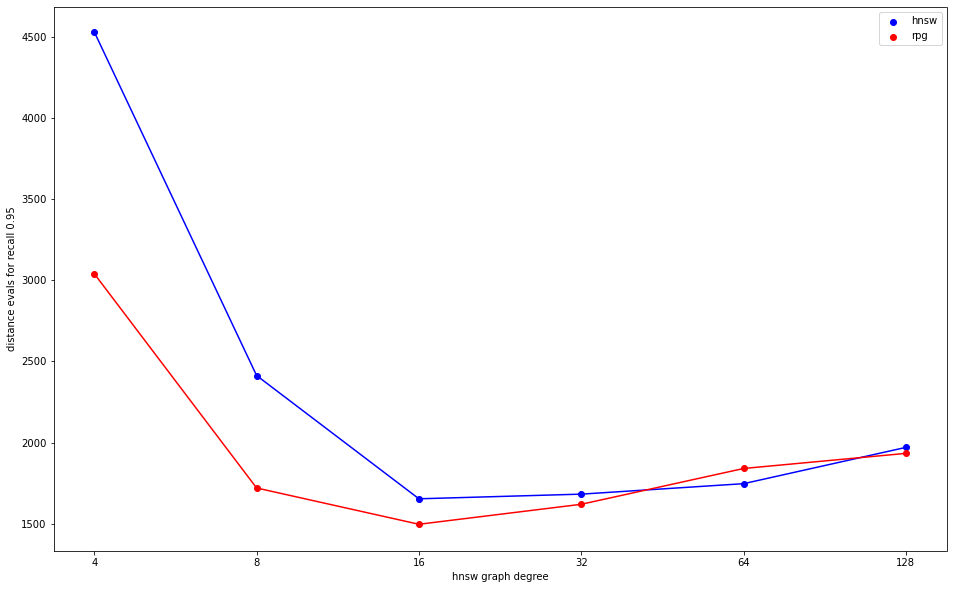

In [19]:
glove_results = eval_hnsw_with_different_degree("glove", 25, recalc=True)
plot_evals_for_recall(glove_results)

Data is ok!
./RPG --mode base --baseSize 1000000 --trainQueries 96 --base data/deep1M/data/items.bin --outputGraph data/deep1M/embed_M4.hnsw --relevanceVector 96 --efConstruction 1000 --M 4 --metric l2
./RPG --mode base --baseSize 1000000 --trainQueries 1000 --base data/deep1M/data/model_scores/gt_train_scores.bin --outputGraph data/deep1M/relevance_M4.hnsw --relevanceVector 1000 --efConstruction 1000 --M 4 --metric l2
./RPG --mode base --baseSize 1000000 --trainQueries 96 --base data/deep1M/data/items.bin --outputGraph data/deep1M/embed_M8.hnsw --relevanceVector 96 --efConstruction 1000 --M 8 --metric l2
./RPG --mode base --baseSize 1000000 --trainQueries 1000 --base data/deep1M/data/model_scores/gt_train_scores.bin --outputGraph data/deep1M/relevance_M8.hnsw --relevanceVector 1000 --efConstruction 1000 --M 8 --metric l2
./RPG --mode base --baseSize 1000000 --trainQueries 96 --base data/deep1M/data/items.bin --outputGraph data/deep1M/embed_M16.hnsw --relevanceVector 96 --efConstructio

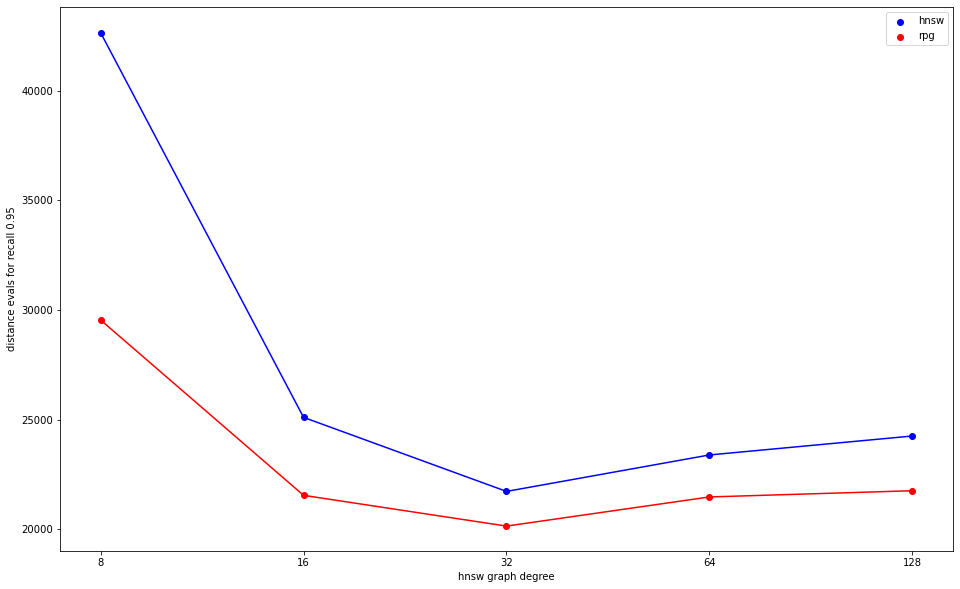

In [23]:
deep_results = eval_hnsw_with_different_degree("deep1M", 96, recalc=True)
plot_evals_for_recall(deep_results)

In [24]:
sift_results = eval_hnsw_with_different_degree("sift", 128, recalc=True)

Data is ok!
./RPG --mode base --baseSize 1000000 --trainQueries 128 --base data/sift/data/items.bin --outputGraph data/sift/embed_M4.hnsw --relevanceVector 128 --efConstruction 1000 --M 4 --metric l2
./RPG --mode base --baseSize 1000000 --trainQueries 1000 --base data/sift/data/model_scores/gt_train_scores.bin --outputGraph data/sift/relevance_M4.hnsw --relevanceVector 1000 --efConstruction 1000 --M 4 --metric l2
./RPG --mode base --baseSize 1000000 --trainQueries 128 --base data/sift/data/items.bin --outputGraph data/sift/embed_M8.hnsw --relevanceVector 128 --efConstruction 1000 --M 8 --metric l2
./RPG --mode base --baseSize 1000000 --trainQueries 1000 --base data/sift/data/model_scores/gt_train_scores.bin --outputGraph data/sift/relevance_M8.hnsw --relevanceVector 1000 --efConstruction 1000 --M 8 --metric l2
./RPG --mode base --baseSize 1000000 --trainQueries 128 --base data/sift/data/items.bin --outputGraph data/sift/embed_M16.hnsw --relevanceVector 128 --efConstruction 1000 --M 16 

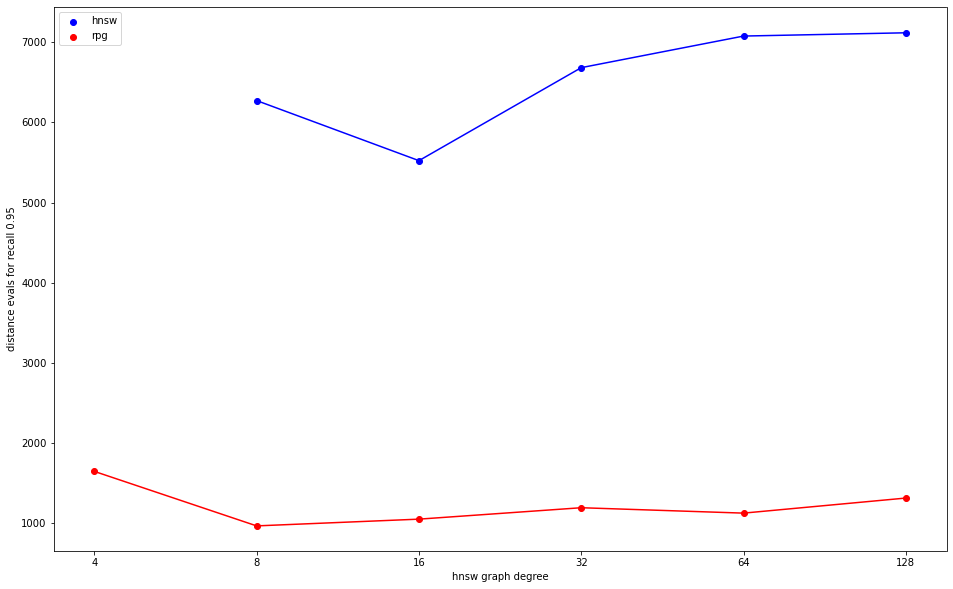

In [25]:
plot_evals_for_recall(sift_results)

In [ ]:
deep256_results = eval_hnsw_with_different_degree("deep256", 256, recalc=True)

Data is ok!
./RPG --mode base --baseSize 1000000 --trainQueries 256 --base data/deep256/data/items.bin --outputGraph data/deep256/embed_M4.hnsw --relevanceVector 256 --efConstruction 1000 --M 4 --metric l2


In [ ]:
plot_evals_for_recall(deep256_results)

In [ ]:
def plot_chosen_results(results, keys=None, xlim=None, ylim=None, x_log_scale=False):
    plt.figure(figsize=(10, 10))
    plt.xlabel("evals")
    plt.ylabel("recall@5")
    if keys is None:
        keys = results.keys()
    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)
    if x_log_scale:
        plt.xscale("log")
    
    plt.plot([0, 10000], [RECALL_OF_INTEREST, RECALL_OF_INTEREST], label="required recall", color="red")
    for key in keys:
        assert key in results
        r = results[key]
        x = r["evals"]
        y = r["recall"]
        plt.plot(x, y, label=key)
        pt_size = 0.1 if len(x) > 100 else 5
        plt.scatter(x, y, s=pt_size)
    plt.legend()
    plt.show()

In [ ]:
plot_chosen_results(
    sift_results,
    keys=[
        "relevance_M8",
        "relevance_M16",
        "embed_M8",
        "embed_M16",
    ],
    xlim=(100,10000),
#     x_log_scale=True
)

In [ ]:
raise StopIteration